# Demo of scikit-learn models

In [1]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
export_images = False

## Synthetic control

In [5]:
from causal_impact.simulate_data import generate_synthetic_control_data

treatment_time = 70
df, weightings_true = generate_synthetic_control_data(treatment_time=treatment_time)

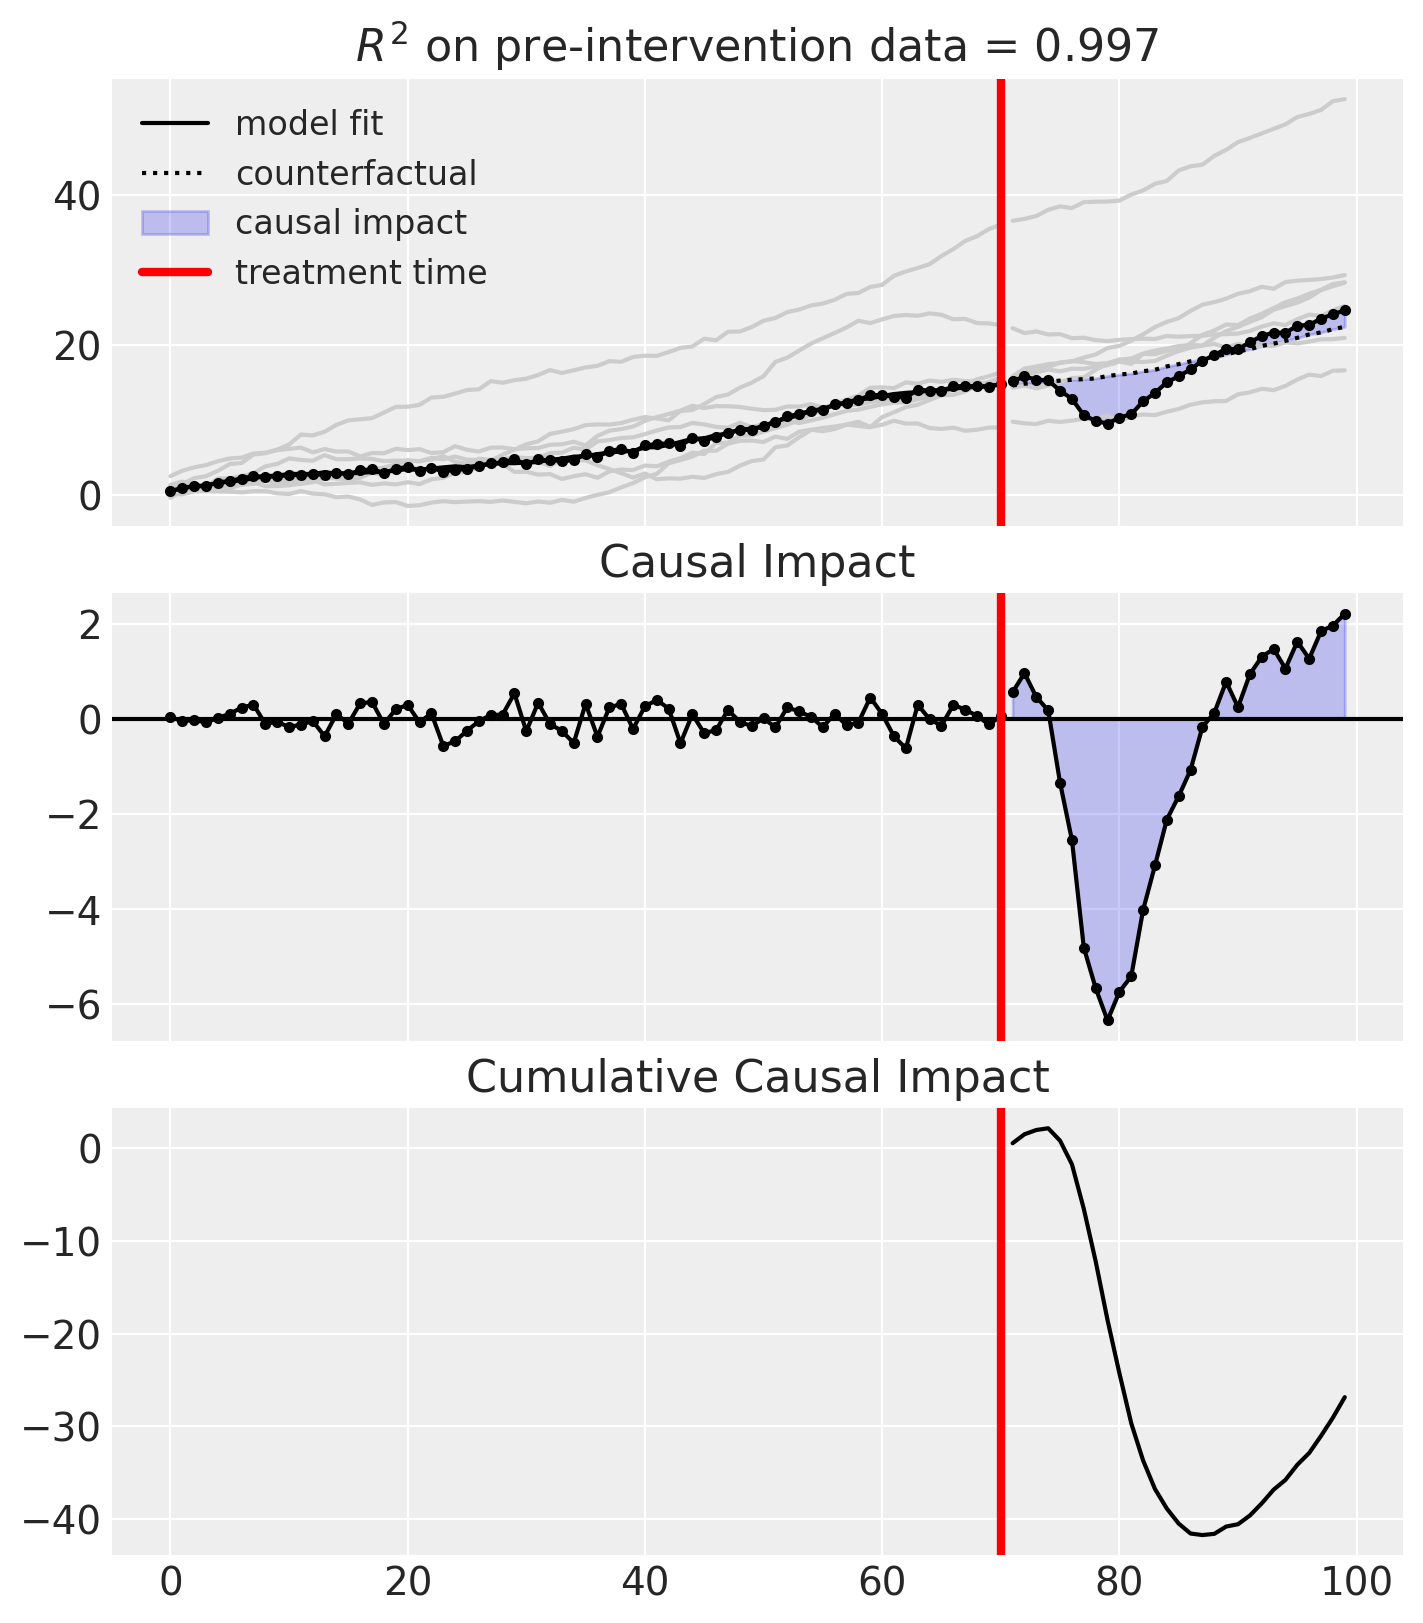

In [6]:
# NOTE: This linear regression example can lead to overfitting
from causal_impact.skl import SyntheticControl
from sklearn.linear_model import LinearRegression

# Note, we do not want an intercept in this model
thing = SyntheticControl(df, 
                         treatment_time, 
                         formula = "actual ~ 0 + a + b + c + d + e + f + g",
                         prediction_model=LinearRegression())

fig, ax = thing.plot()

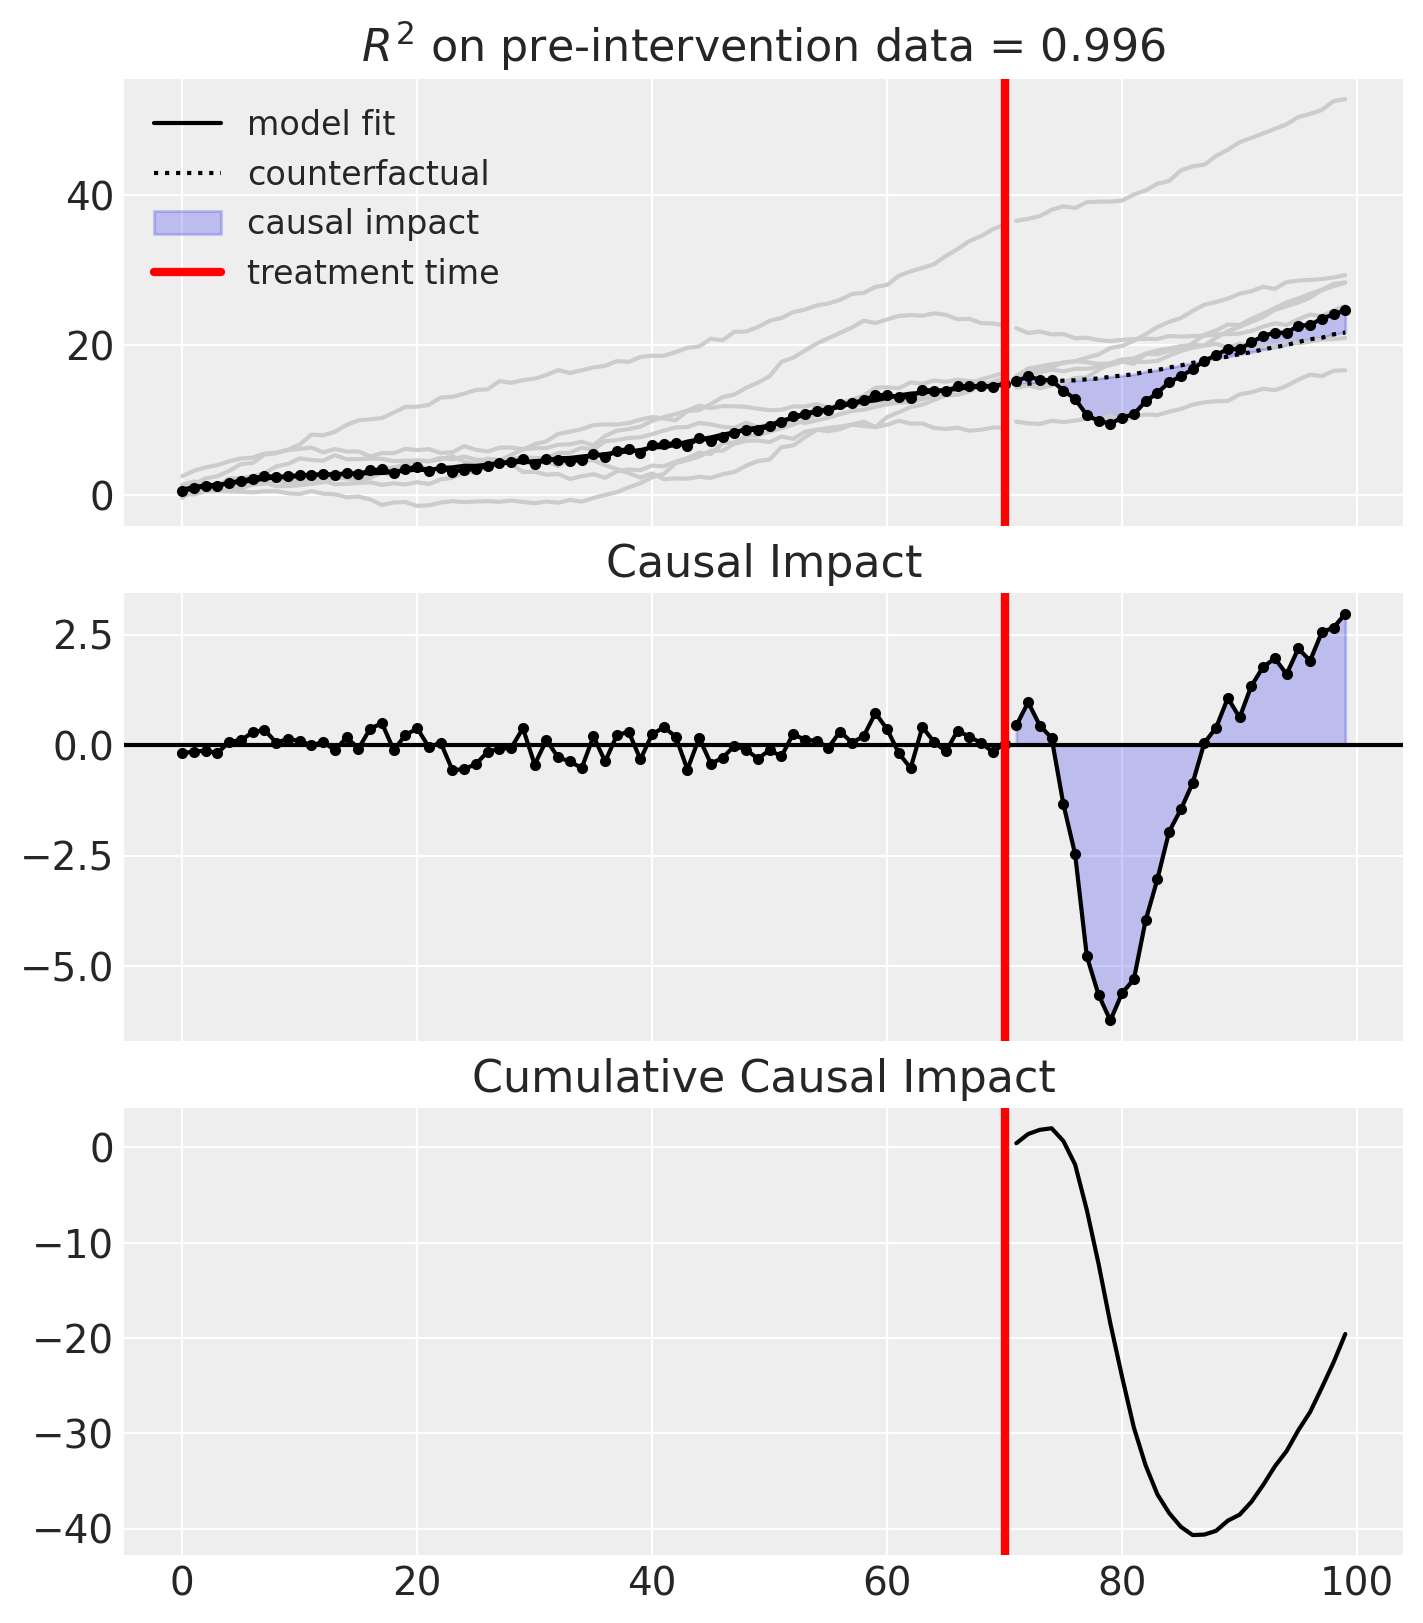

In [7]:
from causal_impact.skl import SyntheticControl
from sklearn.linear_model import Ridge, Lasso

# Note, we do not want an intercept in this model
thing = SyntheticControl(df, 
                         treatment_time, 
                         formula = "actual ~ 0 + a + b + c + d + e + f + g",
                         prediction_model=Ridge(positive=True, alpha=100))

fig, ax = thing.plot()

if export_images:
    plt.savefig('../img/synthetic_control_skl.png', bbox_inches='tight', dpi=300, facecolor="white")

## Interrupted time series

In [8]:
df = pd.read_csv("../causal_impact/data/its_simple.csv")
df.set_index("date", inplace=True)
treatment_time = "2017-01-01"

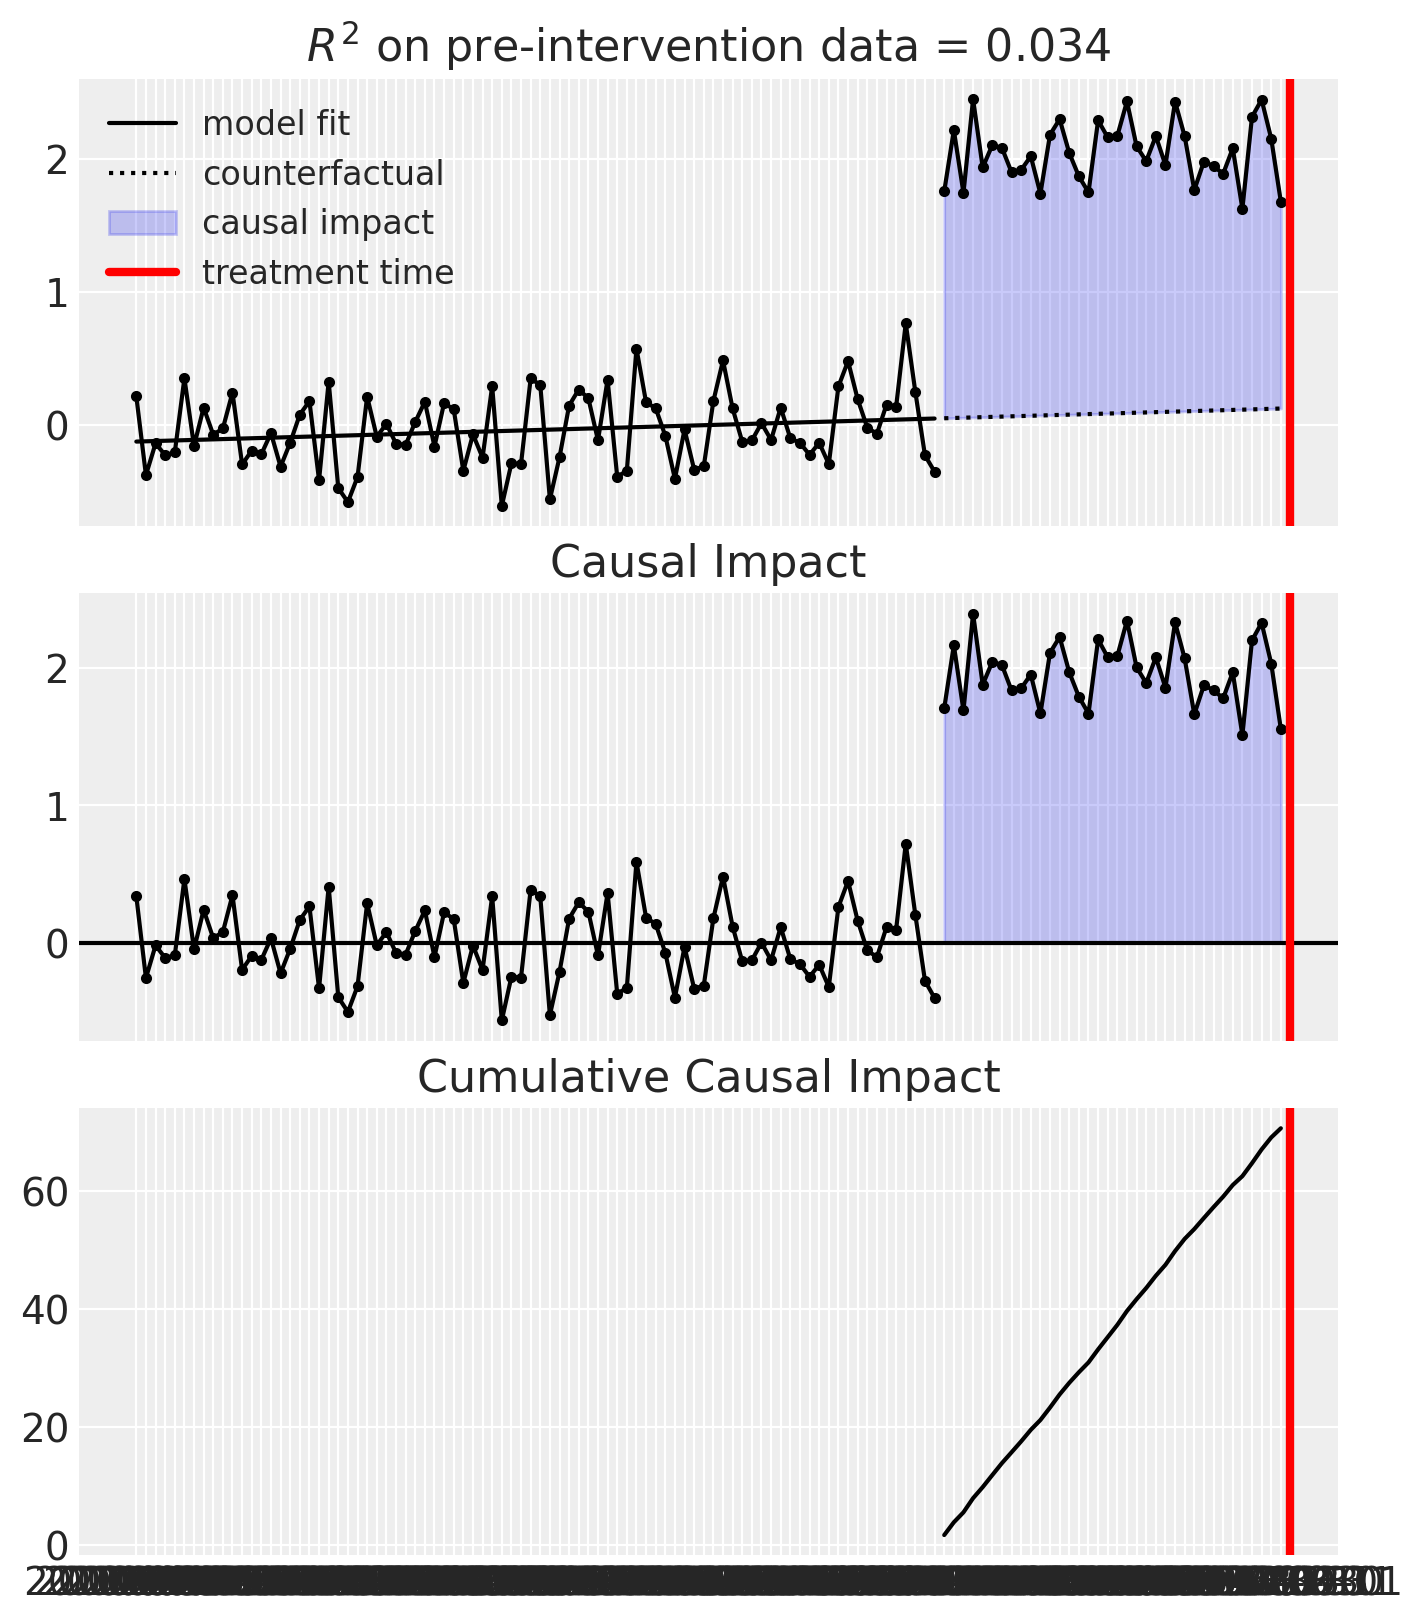

In [9]:
from causal_impact.skl import InterruptedTimeSeries
from sklearn.linear_model import LinearRegression

thing = InterruptedTimeSeries(df, 
                              treatment_time, 
                              formula = 'timeseries ~ 1 + linear_trend', 
                              prediction_model=LinearRegression())

fig, ax = thing.plot()

if export_images:
    plt.savefig('../img/interrupted_time_series_skl.png', bbox_inches='tight', dpi=300, facecolor="white")

## Difference in Differences

In [10]:
data = pd.read_csv("../causal_impact/data/did.csv")

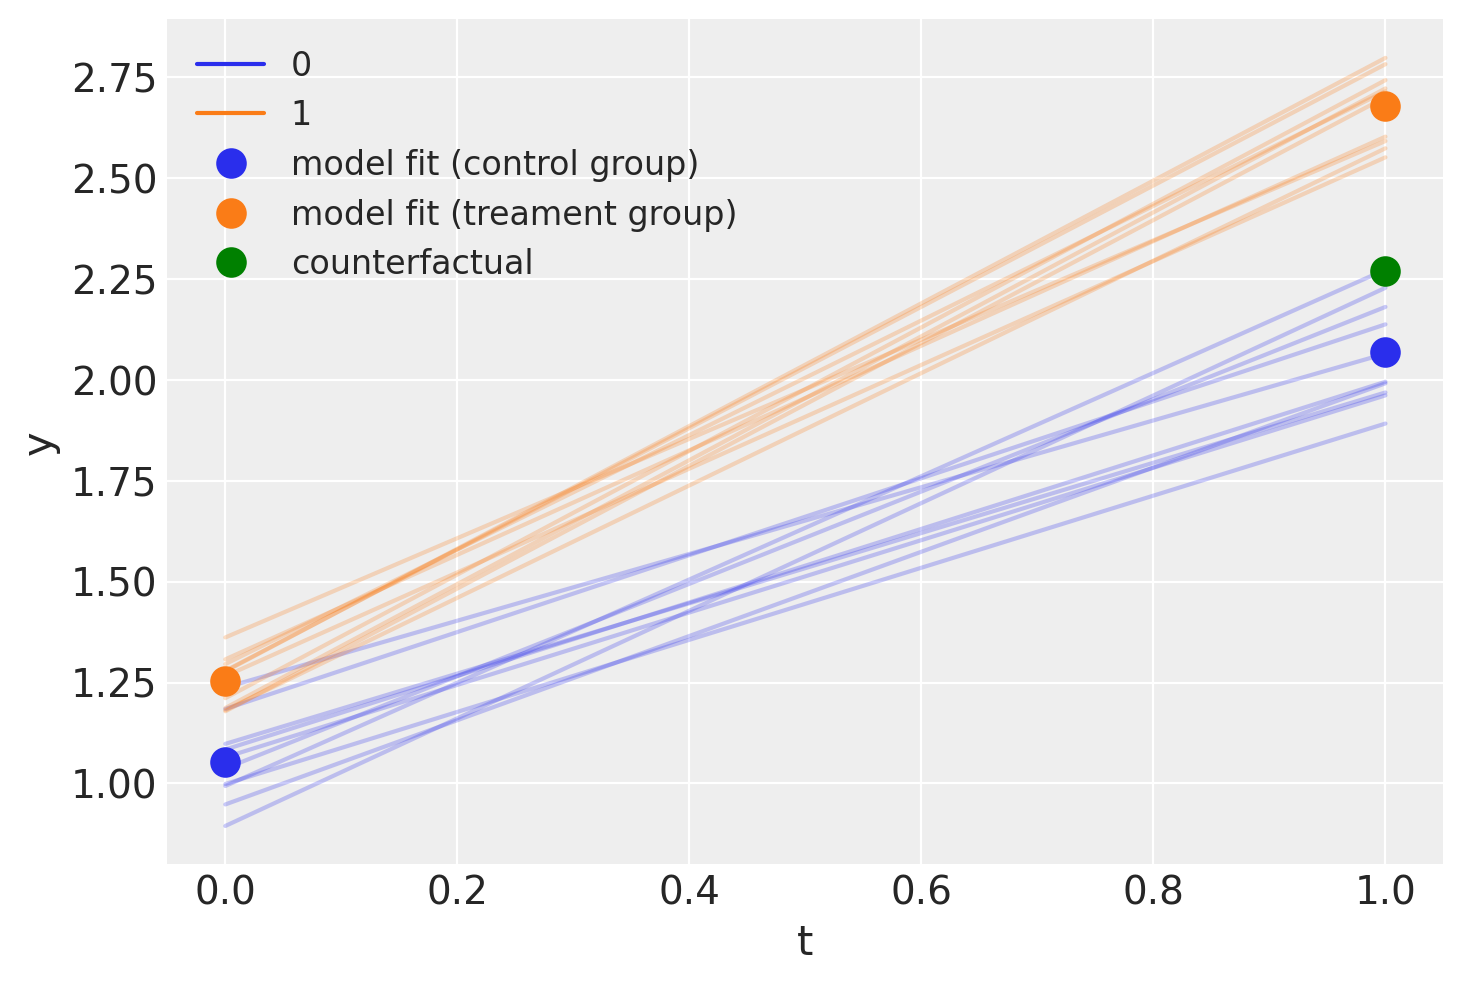

In [11]:
from causal_impact.skl import DifferenceInDifferences
from sklearn.linear_model import LinearRegression

# NOTE: `treated` is a deterministic function of `t` and `group`. So add this function into the formula.

thing = DifferenceInDifferences(data, 
                                formula = 'y ~ 1 + group + t + treated:group',
                                prediction_model=LinearRegression())
fig, ax = thing.plot()

if export_images:
    plt.savefig('../img/difference_in_differences_skl.png', bbox_inches='tight', dpi=300, facecolor="white")

## Regression discontinuity

In [12]:
# # Generate data
# from causal_impact.simulate_data import generate_regression_discontinuity_data
# df = generate_regression_discontinuity_data(true_treatment_threshold=0.5)
# df.to_csv('../causal_impact/data/regression_discontinuity.csv', index=False)

In [13]:
# Load data
data = pd.read_csv('../causal_impact/data/regression_discontinuity.csv')

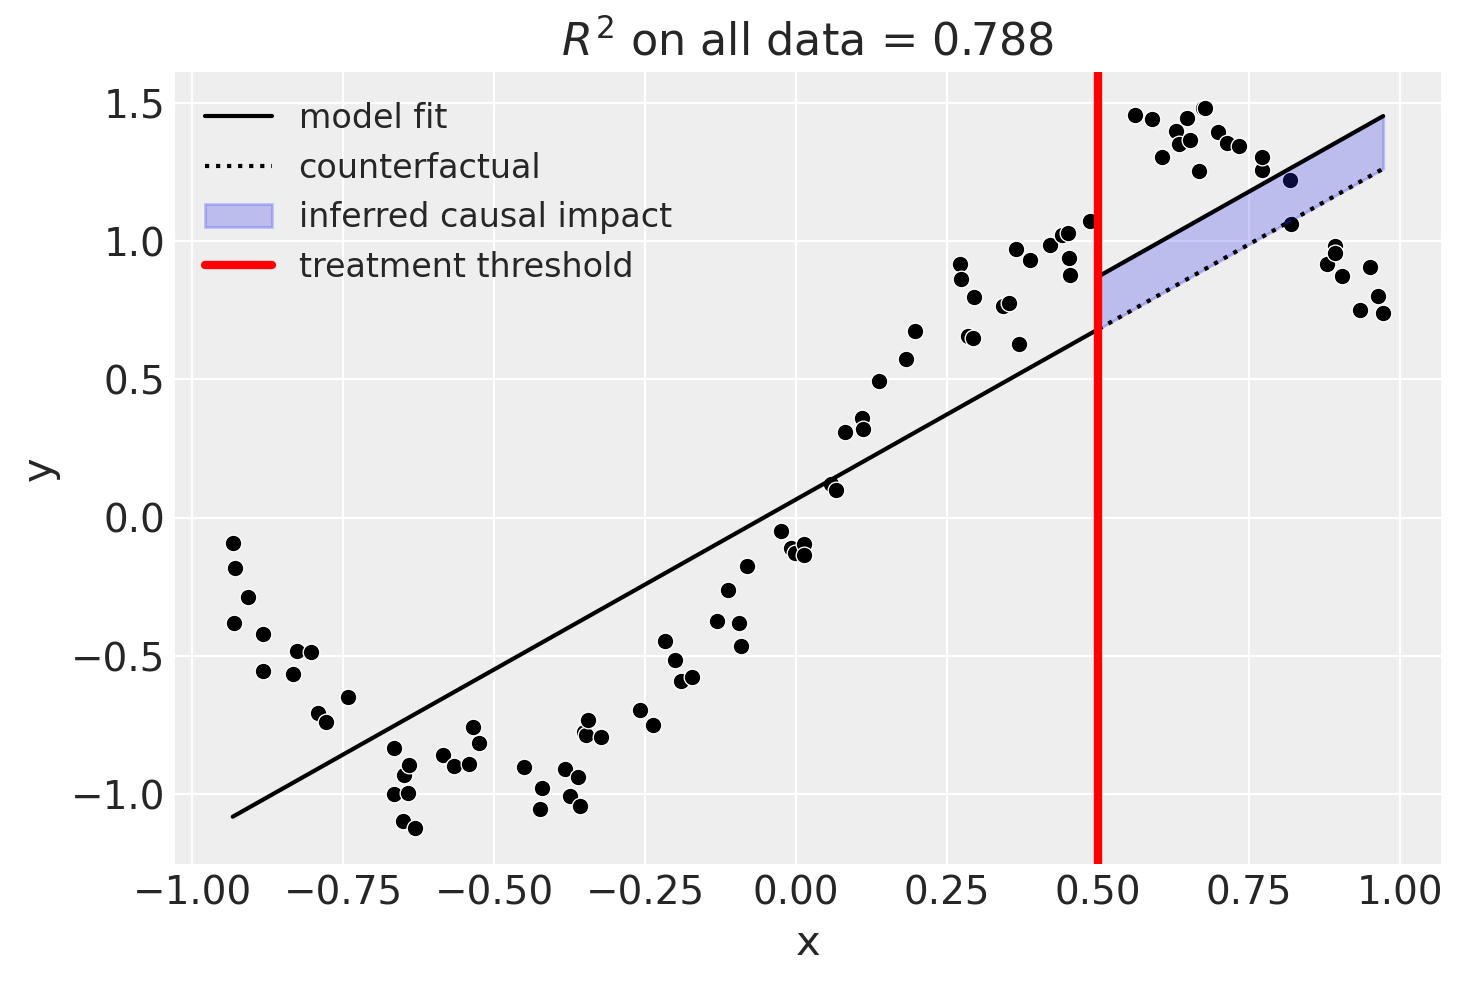

In [14]:
from causal_impact.skl import RegressionDiscontinuity
from sklearn.linear_model import LinearRegression

thing = RegressionDiscontinuity(data, 
                                formula = 'y ~ 1 + x + treated',
                                prediction_model=LinearRegression(),
                                treatment_threshold=0.5)
thing.plot();

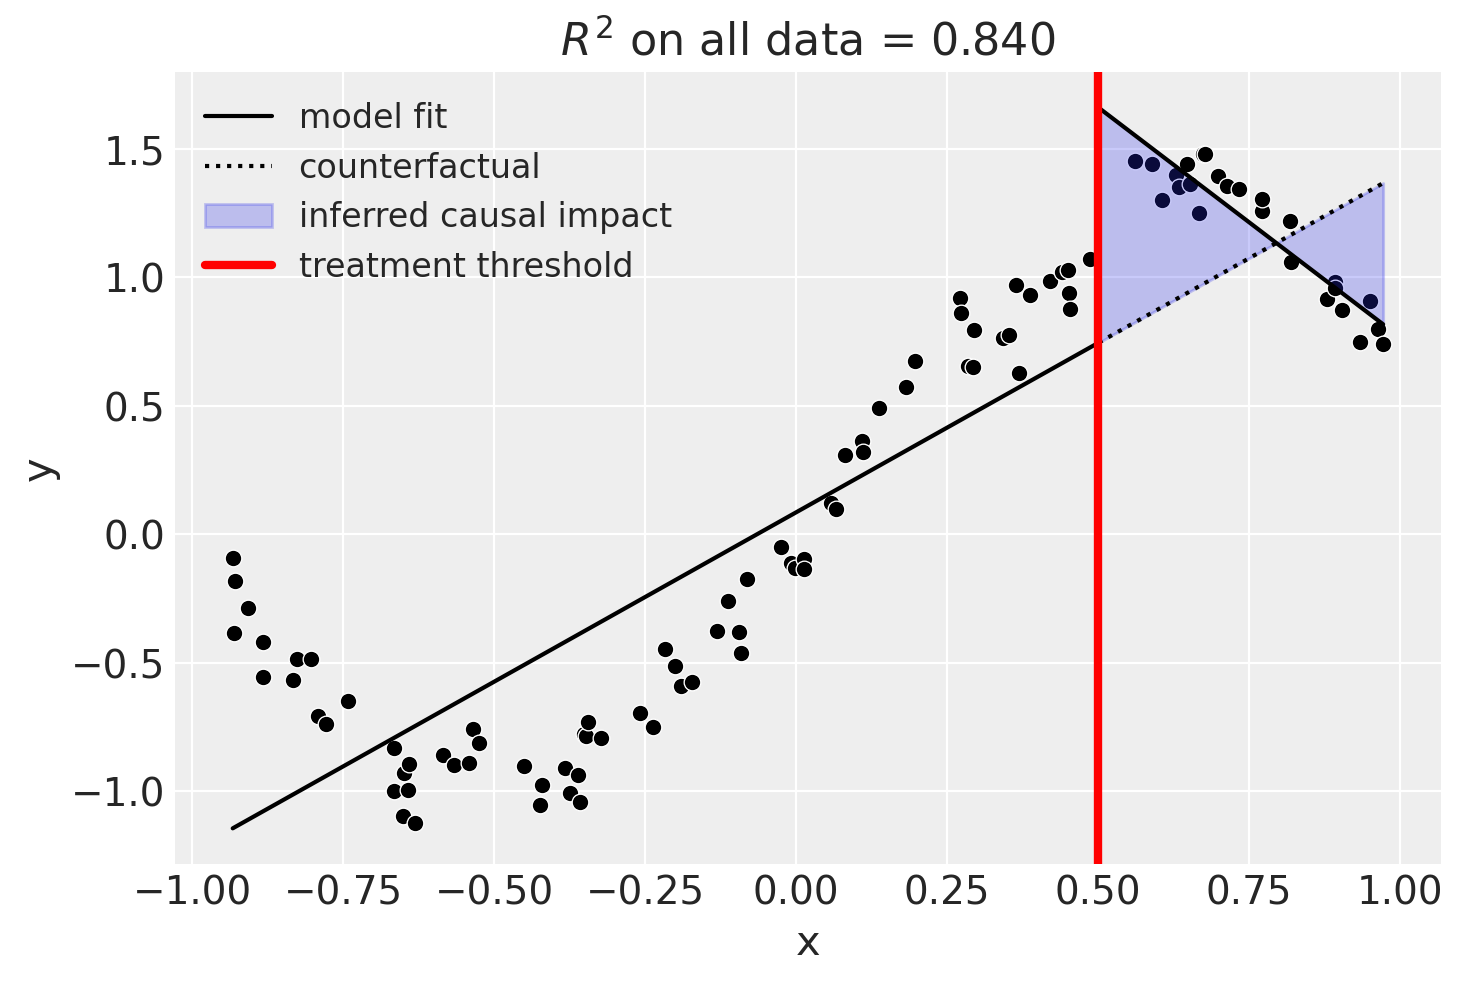

In [15]:
thing = RegressionDiscontinuity(data, 
                                formula = 'y ~ 1 + x + treated + x:treated',
                                prediction_model=LinearRegression(), 
                                treatment_threshold=0.5)
thing.plot();

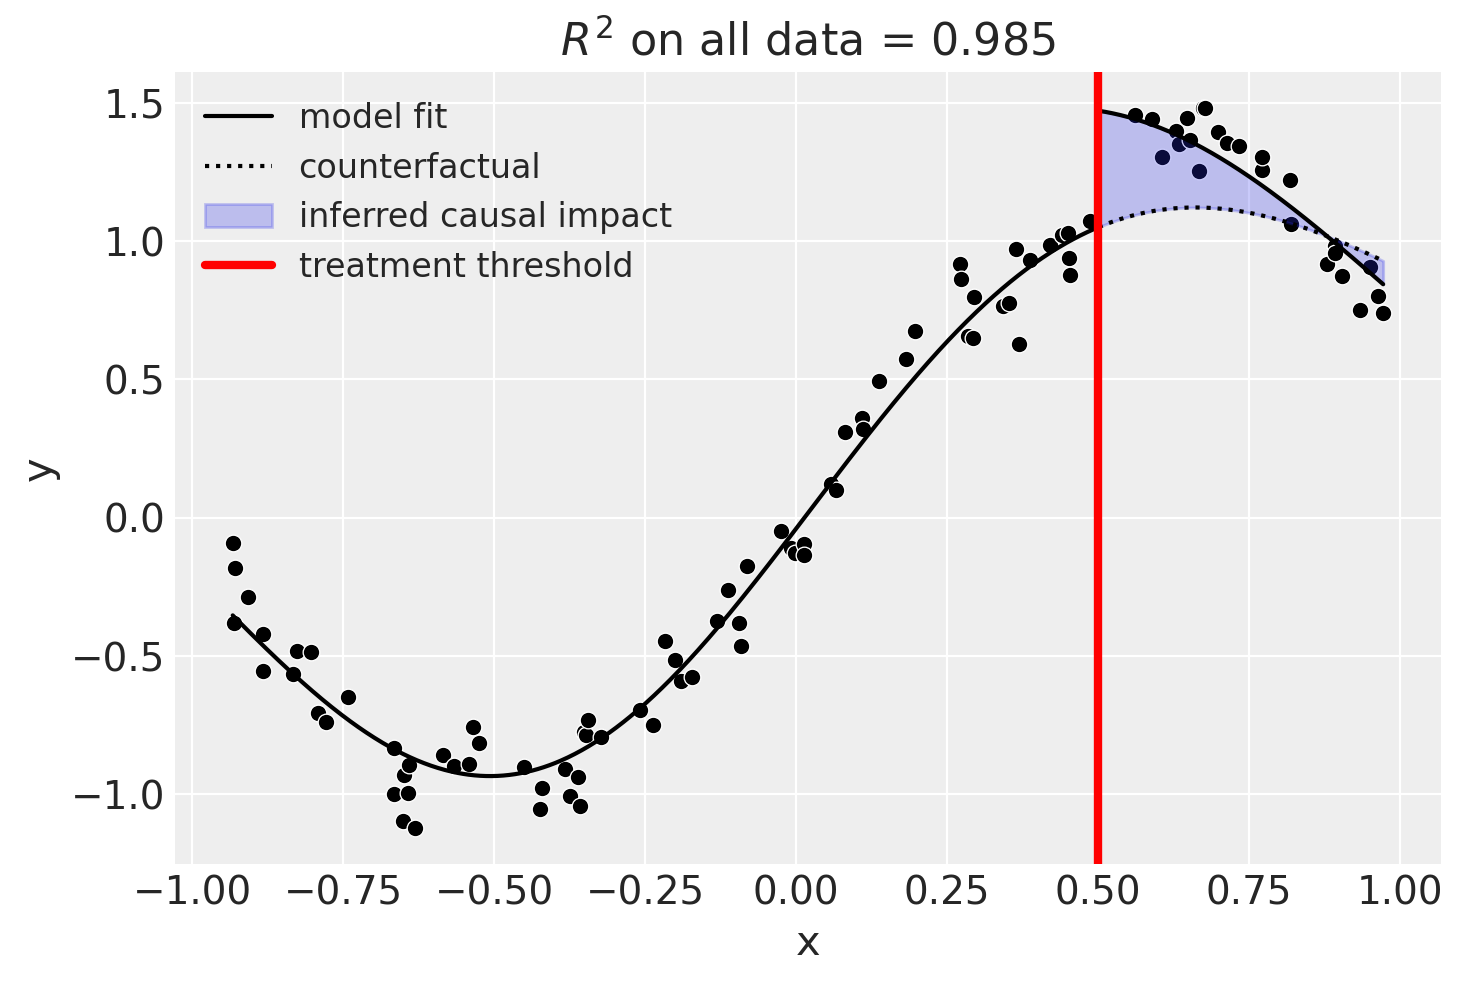

In [16]:
from causal_impact.skl import RegressionDiscontinuity
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

kernel = 1.0 * ExpSineSquared(1.0, 5.0) + WhiteKernel(1e-1)
thing = RegressionDiscontinuity(data, 
                                formula = 'y ~ 1 + x + treated',
                                prediction_model=GaussianProcessRegressor(kernel=kernel), 
                                treatment_threshold=0.5)
fig, ax = thing.plot()

if export_images:
    plt.savefig('../img/regression_discontinuity_skl.png', bbox_inches='tight', dpi=300, facecolor="white")